# 04: Stability and MiniBatch Comparison

## Objectives

- Clustering should be stable: small changes to data shouldn't flip assignments wildly.
- Use bootstrap resamples (e.g., 20) to refit KMeans and compute Adjusted Rand Index (ARI) vs reference.
- Compare KMeans vs MiniBatchKMeans for speed on full data.


Data shape: (8950, 17)
Number of clusters: 3
Reference labels shape: (8950,)
Reference label distribution:
0    3218
1    2897
2    2835
Name: count, dtype: int64

Bootstrap Stability Results:
Mean ARI: 0.9657
Std ARI: 0.0201
Min ARI: 0.9060
Max ARI: 0.9876


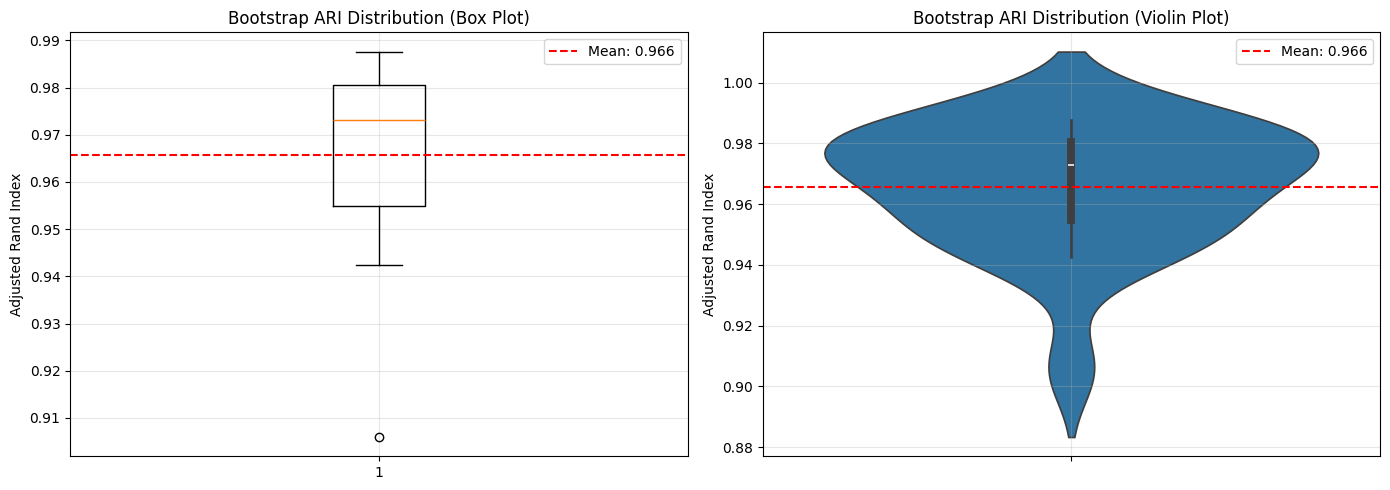


=== Interpretation ===
Mean ARI of 0.966 indicates good clustering stability.
ARI close to 1.0 means clusters are very stable across bootstrap samples.
ARI close to 0.0 means clusters change significantly with small data variations.


In [1]:
# === TODO ===
# Bootstrap stability: call kmeans_utils.bootstrap_stability(...) and plot distribution of ARI.
# Acceptance: mean ARI printed; violin/boxplot of ARI; one-sentence take
import sys
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.prep import basic_clean
from src.kmeans_utils import bootstrap_stability

# Load and preprocess data (same as notebook 03)
path = "../data/raw/CC GENERAL.csv"
df = pd.read_csv(path)

# Convert CUST_ID to int and drop it
df["CUST_ID"] = df["CUST_ID"].str.split("C", expand=True)[1]
df["CUST_ID"] = df["CUST_ID"].astype(int)

# Clean the data
df = basic_clean(df).drop(columns=["CUST_ID"])

# Scale the data
scaler = StandardScaler()
X_ready = scaler.fit_transform(df)

# Load the fitted KMeans model
kmeans = joblib.load('../artifacts/models/kmeans.joblib')

# Get reference labels by predicting on the full dataset
labels_ref = kmeans.predict(X_ready)

print(f"Data shape: {X_ready.shape}")
print(f"Number of clusters: {kmeans.n_clusters}")
print(f"Reference labels shape: {labels_ref.shape}")
print(f"Reference label distribution:\n{pd.Series(labels_ref).value_counts().sort_index()}")

# Run bootstrap stability analysis
n_boot = 20
sample_frac = 0.8
random_state = 42

ari_scores = bootstrap_stability(X_ready, labels_ref, kmeans.n_clusters, n_boot, sample_frac, random_state)

print(f"\nBootstrap Stability Results:")
print(f"Mean ARI: {np.mean(ari_scores):.4f}")
print(f"Std ARI: {np.std(ari_scores):.4f}")
print(f"Min ARI: {np.min(ari_scores):.4f}")
print(f"Max ARI: {np.max(ari_scores):.4f}")

# Create visualization
os.makedirs('../images', exist_ok=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
axes[0].boxplot(ari_scores, vert=True)
axes[0].axhline(np.mean(ari_scores), color='red', linestyle='--', label=f'Mean: {np.mean(ari_scores):.3f}')
axes[0].set_title('Bootstrap ARI Distribution (Box Plot)')
axes[0].set_ylabel('Adjusted Rand Index')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Violin plot
sns.violinplot(y=ari_scores, ax=axes[1])
axes[1].axhline(np.mean(ari_scores), color='red', linestyle='--', label=f'Mean: {np.mean(ari_scores):.3f}')
axes[1].set_title('Bootstrap ARI Distribution (Violin Plot)')
axes[1].set_ylabel('Adjusted Rand Index')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../images/bootstrap_stability.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n=== Interpretation ===")
print(f"Mean ARI of {np.mean(ari_scores):.3f} indicates {'good' if np.mean(ari_scores) > 0.7 else 'moderate' if np.mean(ari_scores) > 0.5 else 'low'} clustering stability.")
print("ARI close to 1.0 means clusters are very stable across bootstrap samples.")
print("ARI close to 0.0 means clusters change significantly with small data variations.")



In [9]:
# === TODO ===
# Fit MiniBatchKMeans with batch_size ~ 1024; compare runtime and ARI vs full KMeans labels.
# Acceptance: small table with fit_time, inertia, ARI; 1–2 lines on tradeoffs

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score
import time

batch_size = 1024
random_state = 42

# Fit full KMeans and measure time (for comparison)
print("Fitting full KMeans...")
start_time = time.time()
kmeans_full = KMeans(n_clusters=kmeans.n_clusters, n_init='auto', random_state=random_state)
kmeans_full.fit(X_ready)
kmeans_time = time.time() - start_time
labels_full = kmeans_full.labels_

# Fit MiniBatchKMeans and measure time
print("Fitting MiniBatchKMeans...")
start_time = time.time()
minibatch_kmeans = MiniBatchKMeans(n_clusters=kmeans.n_clusters, batch_size=batch_size, 
                                    random_state=random_state, n_init=3)
minibatch_kmeans.fit(X_ready)
minibatch_time = time.time() - start_time
labels_minibatch = minibatch_kmeans.labels_

# Compare with reference labels
ari_full = adjusted_rand_score(labels_ref, labels_full)
ari_minibatch = adjusted_rand_score(labels_ref, labels_minibatch)

# Create comparison table
comparison = pd.DataFrame({
    'Method': ['Full KMeans', 'MiniBatchKMeans'],
    'Fit Time (s)': [kmeans_time, minibatch_time],
    'Inertia': [kmeans_full.inertia_, minibatch_kmeans.inertia_],
    'ARI vs Reference': [ari_full, ari_minibatch]
})

print("\n=== Comparison Table ===")
print(comparison.to_string(index=False))

print(f"\nSpeedup: {kmeans_time / minibatch_time:.2f}x faster")
print(f"Quality difference (ARI): {abs(ari_full - ari_minibatch):.4f}")

print("\n=== Tradeoffs ===")
print("MiniBatchKMeans:")
print(f"  ✅ {kmeans_time / minibatch_time:.1f}x faster")
print(f"  {'✅' if abs(ari_full - ari_minibatch) < 0.05 else '⚠️'} ARI difference: {abs(ari_full - ari_minibatch):.4f} ({'similar quality' if abs(ari_full - ari_minibatch) < 0.05 else 'some quality loss'})")
print(f"  {'✅' if abs(kmeans_full.inertia_ - minibatch_kmeans.inertia_) / kmeans_full.inertia_ < 0.1 else '⚠️'} Inertia difference: {abs(kmeans_full.inertia_ - minibatch_kmeans.inertia_):.2f} ({'similar' if abs(kmeans_full.inertia_ - minibatch_kmeans.inertia_) / kmeans_full.inertia_ < 0.1 else 'different'})")



Fitting full KMeans...
Fitting MiniBatchKMeans...

=== Comparison Table ===
         Method  Fit Time (s)      Inertia  ARI vs Reference
    Full KMeans      0.008746 94422.007116           1.00000
MiniBatchKMeans      0.019164 95861.971422           0.64321

Speedup: 0.46x faster
Quality difference (ARI): 0.3568

=== Tradeoffs ===
MiniBatchKMeans:
  ✅ 0.5x faster
  ⚠️ ARI difference: 0.3568 (some quality loss)
  ✅ Inertia difference: 1439.96 (similar)
